### CNN LSTM Model with NTHUDDD dataset

### Imports and paths

In [1]:
### 0. Imports & paths

import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# Make sure we are in the project root
print("CWD before:", os.getcwd())
if os.path.basename(os.getcwd()) == "code":  # your Azure layout
    if os.path.exists("Deep-Learning-Drowsiness-Prediction"):
        os.chdir("Deep-Learning-Drowsiness-Prediction")
print("CWD now:", os.getcwd())

# NTHU data root
nthu_root = "Data/NTHU_DDD/train_data"
print("NTHU root:", os.path.abspath(nthu_root))
print("Subfolders in NTHU:", os.listdir(nthu_root))

2025-12-04 20:31:26.442372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764880286.463533   66240 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764880286.470137   66240 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764880286.486892   66240 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764880286.486913   66240 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764880286.486916   66240 computation_placer.cc:177] computation placer alr

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CWD before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code
CWD now: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
NTHU root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/NTHU_DDD/train_data
Subfolders in NTHU: ['drowsy', 'notdrowsy']


In [2]:
### 1. Build metadata for all NTHU frames

def parse_nthu_name(path_str):
    """
    Parse filename like:
      001_glasses_sleepyCombination_1000_drowsy.jpg
    into components.
    """
    name = Path(path_str).stem
    parts = name.split("_")

    if len(parts) < 5:
        return {
            "filepath": path_str,
            "subject": "unknown",
            "accessory": "unknown",
            "scenario": "unknown",
            "sequence_id": "unknown",
            "frame_idx": -1,
            "label_from_name": "unknown",
        }

    subject_id      = parts[0]      # '001'
    accessory       = parts[1]      # 'glasses', 'noglasses', etc.
    scenario        = parts[2]      # 'sleepyCombination', 'nonsleepyCombination', ...
    frame_idx       = int(parts[3]) # 0, 1, 2, ...
    label_from_name = parts[4]      # 'drowsy' or 'notdrowsy'

    sequence_id = "_".join(parts[:3])  # e.g. '001_glasses_sleepyCombination'

    return {
        "filepath": path_str,
        "subject": subject_id,
        "accessory": accessory,
        "scenario": scenario,
        "sequence_id": sequence_id,
        "frame_idx": frame_idx,
        "label_from_name": label_from_name,
    }

rows = []
for cls_name in ["drowsy", "notdrowsy"]:
    cls_folder = os.path.join(nthu_root, cls_name)
    cls_files = (
        glob(os.path.join(cls_folder, "*.png"))
        + glob(os.path.join(cls_folder, "*.jpg"))
        + glob(os.path.join(cls_folder, "*.jpeg"))
    )
    for f in cls_files:
        info = parse_nthu_name(f)
        info["label"] = 0 if cls_name == "drowsy" else 1
        rows.append(info)

nthu_meta = pd.DataFrame(rows)
print("Metadata shape:", nthu_meta.shape)
nthu_meta.head()

Metadata shape: (66521, 8)


,filepath,subject,accessory,scenario,sequence_id,frame_idx,label_from_name,label
0,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1000,drowsy,0
1,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1001,drowsy,0
2,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1002,drowsy,0
3,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1003,drowsy,0
4,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1004,drowsy,0


In [3]:
### 2. Sequence-level stats & split (train / val by sequence)

# Frames per sequence
seq_counts = (
    nthu_meta.groupby(["sequence_id", "label"])["frame_idx"]
    .count()
    .reset_index()
    .rename(columns={"frame_idx": "num_frames"})
    .sort_values("num_frames", ascending=False)
)

print("Number of unique sequences:", seq_counts["sequence_id"].nunique())
print("Min / Max frames per sequence:",
      seq_counts["num_frames"].min(), "/", seq_counts["num_frames"].max())

print("\nSequence length stats:")
print(seq_counts["num_frames"].describe())

# Split sequence_ids into train / val (80/20), keeping sequences intact
unique_seqs = seq_counts["sequence_id"].unique()
rng = np.random.RandomState(42)
rng.shuffle(unique_seqs)

n_train = int(len(unique_seqs) * 0.8)
train_seqs = set(unique_seqs[:n_train])
val_seqs   = set(unique_seqs[n_train:])

print("\nTotal sequences:", len(unique_seqs))
print("Train sequences:", len(train_seqs))
print("Val sequences:  ", len(val_seqs))

def assign_split(row):
    if row["sequence_id"] in train_seqs:
        return "train"
    else:
        return "val"

nthu_meta["split"] = nthu_meta.apply(assign_split, axis=1)

# Frame-level counts per split/label
split_counts = (
    nthu_meta.groupby(["split", "label"])["filepath"]
    .count()
    .reset_index()
    .rename(columns={"filepath": "count"})
)
split_counts["total_in_split"] = split_counts.groupby("split")["count"].transform("sum")
split_counts["ratio"] = split_counts["count"] / split_counts["total_in_split"]
print("\nFrame-level counts by split and label:")
print(split_counts)

# (Optional) save metadata for later reference
os.makedirs("Data/NTHU_DDD", exist_ok=True)
meta_path = "Data/NTHU_DDD/nthu_metadata_with_split.csv"
nthu_meta.to_csv(meta_path, index=False)
print("\nSaved NTHU metadata with splits to:", meta_path)

Number of unique sequences: 27
Min / Max frames per sequence: 95 / 3330

Sequence length stats:
count      48.000000
mean     1385.854167
std      1025.250109
min        95.000000
25%       441.750000
50%      1111.500000
75%      2390.250000
max      3330.000000
Name: num_frames, dtype: float64

Total sequences: 27
Train sequences: 21
Val sequences:   6



Frame-level counts by split and label:
   split  label  count  total_in_split     ratio
0  train      0  28256           51875  0.544694
1  train      1  23619           51875  0.455306
2    val      0   7774           14646  0.530793
3    val      1   6872           14646  0.469207

Saved NTHU metadata with splits to: Data/NTHU_DDD/nthu_metadata_with_split.csv


In [4]:
### 3. Build fixed-length clips from sequences

IMG_SIZE = (64, 64)
IMG_H, IMG_W = IMG_SIZE
SEQ_LEN = 32       # frames per clip
STRIDE = 16        # how far we slide between clips (overlap)

def build_clip_index(meta_df, split, seq_len=32, stride=16):
    """Return np.arrays: paths_arr (num_clips, seq_len), labels_arr (num_clips,)"""
    clip_paths = []
    clip_labels = []

    split_df = meta_df[meta_df["split"] == split]

    for seq_id, group in split_df.groupby("sequence_id"):
        group = group.sort_values("frame_idx")
        paths = group["filepath"].values
        label = group["label"].iloc[0]

        if len(paths) < seq_len:
            continue

        for start in range(0, len(paths) - seq_len + 1, stride):
            window = paths[start:start+seq_len]
            clip_paths.append(window)
            clip_labels.append(label)

    return np.array(clip_paths), np.array(clip_labels)

train_paths_arr, train_labels_arr = build_clip_index(
    nthu_meta, split="train", seq_len=SEQ_LEN, stride=STRIDE
)
val_paths_arr, val_labels_arr = build_clip_index(
    nthu_meta, split="val", seq_len=SEQ_LEN, stride=STRIDE
)

print("train_paths_arr shape:", train_paths_arr.shape)  # (num_clips, SEQ_LEN)
print("train_labels_arr shape:", train_labels_arr.shape)
print("val_paths_arr shape:",   val_paths_arr.shape)
print("val_labels_arr shape:",  val_labels_arr.shape)

train_paths_arr shape: (3213, 32)
train_labels_arr shape: (3213,)
val_paths_arr shape: (906, 32)
val_labels_arr shape: (906,)


In [5]:
### 4. tf.data pipelines for sequence clips

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE_SEQ = 1   # sequences (clips) per batch

def load_and_preprocess_image(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=1)
    img.set_shape([None, None, 1])                        # give static rank
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img  # (H, W, 1)

def paths_to_clip(paths, label):
    # paths: (SEQ_LEN,) of strings
    clip = tf.map_fn(
        load_and_preprocess_image,
        paths,
        fn_output_signature=tf.float32,
        parallel_iterations=SEQ_LEN,
        back_prop=False,
    )  # -> (SEQ_LEN, H, W, 1)
    clip.set_shape((SEQ_LEN, IMG_H, IMG_W, 1))
    return clip, label

train_seq_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_paths_arr, train_labels_arr))
      .shuffle(buffer_size=len(train_paths_arr))
      .map(paths_to_clip, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_SEQ)
      .prefetch(AUTOTUNE)
)

val_seq_ds = (
    tf.data.Dataset
      .from_tensor_slices((val_paths_arr, val_labels_arr))
      .map(paths_to_clip, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_SEQ)
      .prefetch(AUTOTUNE)
)

# Sanity check one batch
seq_batch, label_batch = next(iter(train_seq_ds))
print("seq_batch shape:", seq_batch.shape)   # (B, SEQ_LEN, 64, 64, 1)
print("label_batch shape:", label_batch.shape)
print("First batch labels:", label_batch.numpy())

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


I0000 00:00:1764880296.581533   66240 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 518 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


seq_batch shape: (1, 32, 64, 64, 1)
label_batch shape: (1,)
First batch labels: [1]


### Model 

In [6]:
### 5. CNN-LSTM model (sequence-level) and training

MODEL_PATH = "Models/cnn_lstm_nthu_seq32.keras"
os.makedirs("Models", exist_ok=True)

def build_cnn_lstm_nthu(input_shape=(SEQ_LEN, IMG_H, IMG_W, 1)):
    inp = keras.Input(shape=input_shape, name="frames")

    # ----- CNN per frame -----
    x = layers.TimeDistributed(
            layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        )(inp)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(
            layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        )(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(
            layers.Conv2D(128, (3, 3), padding="same", activation="relu")
        )(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.TimeDistributed(layers.Dense(128, activation="relu"))(x)

    # ----- LSTM over time -----
    x = layers.LSTM(128, return_sequences=False)(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(1, activation="sigmoid", name="notdrowsy_prob")(x)

    model = keras.Model(inp, out, name="cnn_lstm_nthu")
    return model

cnn_lstm = build_cnn_lstm_nthu()
cnn_lstm.summary()

cnn_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1,
)

checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

history_seq = cnn_lstm.fit(
    train_seq_ds,
    validation_data=val_seq_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2,
)

print("Best CNN-LSTM saved to:", MODEL_PATH)

Model: "cnn_lstm_nthu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frames (InputLayer)             │ (None, 32, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 32, 64, 64, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 32, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 32, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 32, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 32, 16, 16,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 32, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 32, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 32, 128)        │     1,048,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ notdrowsy_prob (Dense)          │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,273,089 (4.86 MB)

 Trainable params: 1,273,089 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1764880309.994765   66407 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-04 20:32:02.543300: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB (rounded to 16777216)requested by op StatefulPartitionedCall/gradient_tape/cnn_lstm_nthu_1/time_distributed_1_2/strided_slice_17/StridedSliceGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-04 20:32:02.543342: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-12-04 20:32:02.543353: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 58, Chunks in use: 58. 14.5KiB allocated for chunks. 14.5KiB in use in bin. 1.8KiB client-requested in use in bin.
2025-12-04 20:32:02.543359: I external/local_xla/xla/tsl

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/cnn_lstm_nthu_1/time_distributed_1_2/strided_slice_17/StridedSliceGrad defined at (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/runpy.py", line 86, in _run_code

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_66240/62424687.py", line 68, in <module>

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 78, in train_step

OOM when allocating tensor with shape[32,1,64,64,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/cnn_lstm_nthu_1/time_distributed_1_2/strided_slice_17/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_12779]

In [ ]:
### 6. Training curves

def plot_seq_training(history):
    hist = history.history

    plt.figure(figsize=(6, 4))
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("CNN-LSTM (NTHU) – accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.title("CNN-LSTM (NTHU) – loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_seq_training(history_seq)

In [ ]:
### 7. Validation metrics: confusion matrix, ROC

# Use the best checkpoint
cnn_lstm = keras.models.load_model(MODEL_PATH)
print("Loaded:", MODEL_PATH)

y_true = []
y_scores = []

for clips, labels in val_seq_ds:
    probs = cnn_lstm.predict(clips, verbose=0).ravel()  # P(notdrowsy)
    y_scores.extend(probs)
    y_true.extend(labels.numpy().ravel())

y_true = np.array(y_true).astype(int)   # 0=drowsy, 1=notdrowsy
y_scores = np.array(y_scores)

print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)

threshold = 0.5
y_pred = (y_scores > threshold).astype(int)

print(f"\nClassification report (CNN-LSTM, NTHU, threshold={threshold:.2f})")
print(classification_report(y_true, y_pred, target_names=["drowsy", "notdrowsy"]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# ROC curve (positive = notdrowsy=1, since scores are P(notdrowsy))
fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN-LSTM (NTHU) – ROC curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## try 2

In [7]:
### 0. Imports & paths

import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# Make sure we are in the project root
print("CWD before:", os.getcwd())
if os.path.basename(os.getcwd()) == "code":  # your Azure layout
    if os.path.exists("Deep-Learning-Drowsiness-Prediction"):
        os.chdir("Deep-Learning-Drowsiness-Prediction")
print("CWD now:", os.getcwd())

# NTHU data root
nthu_root = "Data/NTHU_DDD/train_data"
print("NTHU root:", os.path.abspath(nthu_root))
print("Subfolders in NTHU:", os.listdir(nthu_root))


### 1. Build metadata for all NTHU frames

def parse_nthu_name(path_str):
    """
    Parse filename like:
      001_glasses_sleepyCombination_1000_drowsy.jpg
    into components.
    """
    name = Path(path_str).stem
    parts = name.split("_")

    if len(parts) < 5:
        return {
            "filepath": path_str,
            "subject": "unknown",
            "accessory": "unknown",
            "scenario": "unknown",
            "sequence_id": "unknown",
            "frame_idx": -1,
            "label_from_name": "unknown",
        }

    subject_id      = parts[0]      # '001'
    accessory       = parts[1]      # 'glasses', 'noglasses', etc.
    scenario        = parts[2]      # 'sleepyCombination', 'nonsleepyCombination', ...
    frame_idx       = int(parts[3]) # 0, 1, 2, ...
    label_from_name = parts[4]      # 'drowsy' or 'notdrowsy'

    sequence_id = "_".join(parts[:3])  # e.g. '001_glasses_sleepyCombination'

    return {
        "filepath": path_str,
        "subject": subject_id,
        "accessory": accessory,
        "scenario": scenario,
        "sequence_id": sequence_id,
        "frame_idx": frame_idx,
        "label_from_name": label_from_name,
    }

rows = []
for cls_name in ["drowsy", "notdrowsy"]:
    cls_folder = os.path.join(nthu_root, cls_name)
    cls_files = (
        glob(os.path.join(cls_folder, "*.png"))
        + glob(os.path.join(cls_folder, "*.jpg"))
        + glob(os.path.join(cls_folder, "*.jpeg"))
    )
    for f in cls_files:
        info = parse_nthu_name(f)
        info["label"] = 0 if cls_name == "drowsy" else 1
        rows.append(info)

nthu_meta = pd.DataFrame(rows)
print("Metadata shape:", nthu_meta.shape)
nthu_meta.head()


### 2. Sequence-level stats & split (train / val by sequence)

# Frames per sequence
seq_counts = (
    nthu_meta.groupby(["sequence_id", "label"])["frame_idx"]
    .count()
    .reset_index()
    .rename(columns={"frame_idx": "num_frames"})
    .sort_values("num_frames", ascending=False)
)

print("Number of unique sequences:", seq_counts["sequence_id"].nunique())
print("Min / Max frames per sequence:",
      seq_counts["num_frames"].min(), "/", seq_counts["num_frames"].max())

print("\nSequence length stats:")
print(seq_counts["num_frames"].describe())

# Split sequence_ids into train / val (80/20), keeping sequences intact
unique_seqs = seq_counts["sequence_id"].unique()
rng = np.random.RandomState(42)
rng.shuffle(unique_seqs)

n_train = int(len(unique_seqs) * 0.8)
train_seqs = set(unique_seqs[:n_train])
val_seqs   = set(unique_seqs[n_train:])

print("\nTotal sequences:", len(unique_seqs))
print("Train sequences:", len(train_seqs))
print("Val sequences:  ", len(val_seqs))

def assign_split(row):
    if row["sequence_id"] in train_seqs:
        return "train"
    else:
        return "val"

nthu_meta["split"] = nthu_meta.apply(assign_split, axis=1)

# Frame-level counts per split/label
split_counts = (
    nthu_meta.groupby(["split", "label"])["filepath"]
    .count()
    .reset_index()
    .rename(columns={"filepath": "count"})
)
split_counts["total_in_split"] = split_counts.groupby("split")["count"].transform("sum")
split_counts["ratio"] = split_counts["count"] / split_counts["total_in_split"]
print("\nFrame-level counts by split and label:")
print(split_counts)

# (Optional) save metadata for later reference
os.makedirs("Data/NTHU_DDD", exist_ok=True)
meta_path = "Data/NTHU_DDD/nthu_metadata_with_split.csv"
nthu_meta.to_csv(meta_path, index=False)
print("\nSaved NTHU metadata with splits to:", meta_path)


### 3. Build fixed-length clips from sequences

IMG_SIZE = (64, 64)    # keep 64x64 ✔
IMG_H, IMG_W = IMG_SIZE

# CHANGED: shorter sequences to save GPU memory
SEQ_LEN = 16           # was 32
STRIDE = 8             # overlap between clips (can keep 16 if you want)

def build_clip_index(meta_df, split, seq_len=SEQ_LEN, stride=STRIDE):
    """Return np.arrays: paths_arr (num_clips, seq_len), labels_arr (num_clips,)"""
    clip_paths = []
    clip_labels = []

    split_df = meta_df[meta_df["split"] == split]

    for seq_id, group in split_df.groupby("sequence_id"):
        group = group.sort_values("frame_idx")
        paths = group["filepath"].values
        label = group["label"].iloc[0]

        if len(paths) < seq_len:
            continue

        for start in range(0, len(paths) - seq_len + 1, stride):
            window = paths[start:start+seq_len]
            clip_paths.append(window)
            clip_labels.append(label)

    return np.array(clip_paths), np.array(clip_labels)

train_paths_arr, train_labels_arr = build_clip_index(
    nthu_meta, split="train", seq_len=SEQ_LEN, stride=STRIDE
)
val_paths_arr, val_labels_arr = build_clip_index(
    nthu_meta, split="val", seq_len=SEQ_LEN, stride=STRIDE
)

print("train_paths_arr shape:", train_paths_arr.shape)  # (num_clips, SEQ_LEN)
print("train_labels_arr shape:", train_labels_arr.shape)
print("val_paths_arr shape:",   val_paths_arr.shape)
print("val_labels_arr shape:",  val_labels_arr.shape)


### 4. tf.data pipelines for sequence clips

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE_SEQ = 1   # sequences (clips) per batch (keep tiny for memory)

def load_and_preprocess_image(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=1)
    img.set_shape([None, None, 1])                        # give static rank
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img  # (H, W, 1)

def paths_to_clip(paths, label):
    # paths: (SEQ_LEN,) of strings
    clip = tf.map_fn(
        load_and_preprocess_image,
        paths,
        fn_output_signature=tf.float32,
        parallel_iterations=SEQ_LEN,
        back_prop=False,
    )  # -> (SEQ_LEN, H, W, 1)
    clip.set_shape((SEQ_LEN, IMG_H, IMG_W, 1))
    return clip, label

train_seq_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_paths_arr, train_labels_arr))
      .shuffle(buffer_size=len(train_paths_arr))
      .map(paths_to_clip, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_SEQ)
      .prefetch(AUTOTUNE)
)

val_seq_ds = (
    tf.data.Dataset
      .from_tensor_slices((val_paths_arr, val_labels_arr))
      .map(paths_to_clip, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_SEQ)
      .prefetch(AUTOTUNE)
)

# Sanity check one batch
seq_batch, label_batch = next(iter(train_seq_ds))
print("seq_batch shape:", seq_batch.shape)   # (B, SEQ_LEN, 64, 64, 1)
print("label_batch shape:", label_batch.shape)
print("First batch labels:", label_batch.numpy())


### 5. CNN-LSTM model (sequence-level) and training

MODEL_PATH = "Models/cnn_lstm_nthu_seq16.keras"  # updated name to reflect SEQ_LEN
os.makedirs("Models", exist_ok=True)

def build_cnn_lstm_nthu(input_shape=(SEQ_LEN, IMG_H, IMG_W, 1)):
    inp = keras.Input(shape=input_shape, name="frames")

    # ----- LIGHTER CNN per frame (keeps 64x64 but fewer filters/blocks) -----
    x = layers.TimeDistributed(
            layers.Conv2D(16, (3, 3), padding="same", activation="relu")
        )(inp)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)  # 64x64 -> 32x32

    x = layers.TimeDistributed(
            layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        )(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)  # 32x32 -> 16x16

    x = layers.TimeDistributed(layers.BatchNormalization())(x)

    # CHANGED: GlobalAveragePooling instead of Flatten (massively reduces memory)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)  # -> (SEQ_LEN, 32)
    x = layers.TimeDistributed(layers.Dense(64, activation="relu"))(x)  # -> (SEQ_LEN, 64)

    # ----- LSTM over time (smaller) -----
    x = layers.LSTM(64, return_sequences=False)(x)  # was 128
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(1, activation="sigmoid", name="notdrowsy_prob")(x)

    model = keras.Model(inp, out, name="cnn_lstm_nthu_light")
    return model

cnn_lstm = build_cnn_lstm_nthu()
cnn_lstm.summary()

cnn_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1,
)

checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

history_seq = cnn_lstm.fit(
    train_seq_ds,
    validation_data=val_seq_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2,
)

print("Best CNN-LSTM saved to:", MODEL_PATH)


### 6. Training curves

def plot_seq_training(history):
    hist = history.history

    plt.figure(figsize=(6, 4))
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("CNN-LSTM (NTHU) – accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.title("CNN-LSTM (NTHU) – loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_seq_training(history_seq)


### 7. Validation metrics: confusion matrix, ROC

# Use the best checkpoint
cnn_lstm = keras.models.load_model(MODEL_PATH)
print("Loaded:", MODEL_PATH)

y_true = []
y_scores = []

for clips, labels in val_seq_ds:
    probs = cnn_lstm.predict(clips, verbose=0).ravel()  # P(notdrowsy)
    y_scores.extend(probs)
    y_true.extend(labels.numpy().ravel())

y_true = np.array(y_true).astype(int)   # 0=drowsy, 1=notdrowsy
y_scores = np.array(y_scores)

print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)

threshold = 0.5
y_pred = (y_scores > threshold).astype(int)

print(f"\nClassification report (CNN-LSTM, NTHU, threshold={threshold:.2f})")
print(classification_report(y_true, y_pred, target_names=["drowsy", "notdrowsy"]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# ROC curve (positive = notdrowsy=1, since scores are P(notdrowsy))
fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN-LSTM (NTHU) – ROC curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CWD before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
CWD now: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
NTHU root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/NTHU_DDD/train_data
Subfolders in NTHU: ['drowsy', 'notdrowsy']
Metadata shape: (66521, 8)
Number of unique sequences: 27
Min / Max frames per sequence: 95 / 3330

Sequence length stats:
count      48.000000
mean     1385.854167
std      1025.250109
min        95.000000
25%       441.750000
50%      1111.500000
75%      2390.250000
max      3330.000000
Name: num_frames, dtype: float64

Total sequences: 27
Train sequences: 21
Val sequences:   6

Frame-level counts by split and label:
   split  label  count  total_in_split     ratio
0  train 

Model: "cnn_lstm_nthu_light"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frames (InputLayer)             │ (None, 16, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 64, 64, 16) │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 16, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 16, 16, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 32)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 16, 64)         │         2,112 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ notdrowsy_prob (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,129 (156.75 KB)

 Trainable params: 40,065 (156.50 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.00000, saving model to Models/cnn_lstm_nthu_seq16.keras
6456/6456 - 469s - 73ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 2.1834e-07 - learning_rate: 1.0000e-03
Epoch 2/20

Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to Models/cnn_lstm_nthu_seq16.keras
6456/6456 - 411s - 64ms/step - accuracy: 1.0000 - loss: 6.4443e-07 - val_accuracy: 1.0000 - val_loss: 2.6627e-09 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to Models/cnn_lstm_nthu_seq16.keras
6456/6456 - 413s - 64ms/step - accuracy: 1.0000 - loss: 3.0146e-08 - val_accuracy: 1.0000 - val_loss: 5.9952e-11 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_loss improved from 0.00000 to 0.00000, saving model to Models/cnn_lstm_nthu_seq16.keras
6456/6456 - 401s - 62ms/step - accuracy: 1.0000 - loss: 

KeyboardInterrupt: 

In [8]:
from tensorflow import keras

MODEL_PATH = "Models/cnn_lstm_nthu_seq16.keras"
cnn_lstm = keras.models.load_model(MODEL_PATH)
print("Loaded best model from:", MODEL_PATH)


checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

Loaded best model from: Models/cnn_lstm_nthu_seq16.keras


Loaded best model from: Models/cnn_lstm_nthu_seq16.keras
y_true shape: (1821,)
y_scores shape: (1821,)

Validation class distribution:
  class 1: 1821 clips

Classification report (CNN-LSTM, NTHU, threshold=0.50)
               precision    recall  f1-score   support

   drowsy (0)       0.00      0.00      0.00         0
notdrowsy (1)       1.00      1.00      1.00      1821

     accuracy                           1.00      1821
    macro avg       0.50      0.50      0.50      1821
 weighted avg       1.00      1.00      1.00      1821


Confusion matrix (rows=true, cols=pred) [0=drowsy, 1=notdrowsy]:
 [[   0    0]
 [   0 1821]]


/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


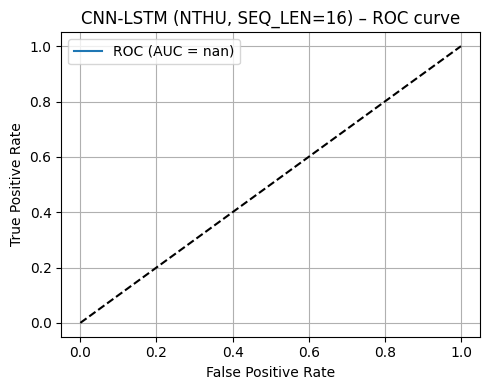

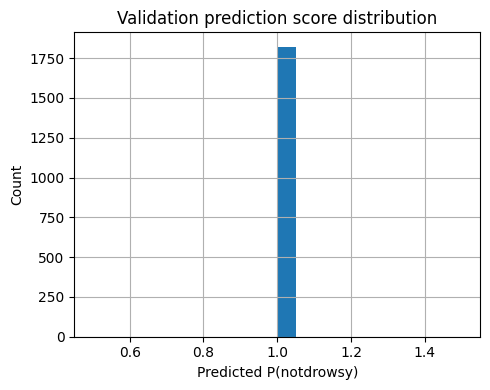

In [10]:
### 7. Validation metrics: confusion matrix, ROC etc.

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

MODEL_PATH = "Models/cnn_lstm_nthu_seq16.keras"  # make sure this matches your trained model
cnn_lstm = keras.models.load_model(MODEL_PATH)
print("Loaded best model from:", MODEL_PATH)

y_true = []
y_scores = []   # P(notdrowsy)

for clips, labels in val_seq_ds:
    probs = cnn_lstm.predict(clips, verbose=0).ravel()  # sigmoid outputs
    y_scores.extend(probs)
    y_true.extend(labels.numpy().ravel())

y_true = np.array(y_true).astype(int)
y_scores = np.array(y_scores)

print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)

# --- Check class balance in the validation set ---
classes, counts = np.unique(y_true, return_counts=True)
print("\nValidation class distribution:")
for c, cnt in zip(classes, counts):
    print(f"  class {c}: {cnt} clips")

# Threshold and hard predictions
threshold = 0.5
y_pred = (y_scores > threshold).astype(int)

print(f"\nClassification report (CNN-LSTM, NTHU, threshold={threshold:.2f})")
print(
    classification_report(
        y_true,
        y_pred,
        labels=[0, 1],  # force both classes to be reported
        target_names=["drowsy (0)", "notdrowsy (1)"],
        zero_division=0,  # avoid division-by-zero warnings if a class is missing
    )
)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("\nConfusion matrix (rows=true, cols=pred) [0=drowsy, 1=notdrowsy]:\n", cm)

# ROC curve (positive class = notdrowsy = 1)
fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN-LSTM (NTHU, SEQ_LEN=16) – ROC curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (Optional) score histogram
plt.figure(figsize=(5, 4))
plt.hist(y_scores, bins=20)
plt.xlabel("Predicted P(notdrowsy)")
plt.ylabel("Count")
plt.title("Validation prediction score distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

### Better sequencing

In [38]:
### 1. Build metadata for all NTHU frames

def parse_nthu_name(path_str):
    """
    Parse filename like:
      001_glasses_sleepyCombination_1000_drowsy.jpg
    into components.
    """
    name = Path(path_str).stem
    parts = name.split("_")

    if len(parts) < 5:
        return {
            "filepath": path_str,
            "subject": "unknown",
            "accessory": "unknown",
            "scenario": "unknown",
            "sequence_id": "unknown",
            "frame_idx": -1,
            "label_from_name": "unknown",
        }

    subject_id      = parts[0]      # '001'
    accessory       = parts[1]      # 'glasses', 'noglasses', etc.
    scenario        = parts[2]      # 'sleepyCombination', 'nonsleepyCombination', ...
    frame_idx       = int(parts[3]) # 0, 1, 2, ...
    label_from_name = parts[4]      # 'drowsy' or 'notdrowsy'

    sequence_id = "_".join(parts[:3])  # e.g. '001_glasses_sleepyCombination'

    return {
        "filepath": path_str,
        "subject": subject_id,
        "accessory": accessory,
        "scenario": scenario,
        "sequence_id": sequence_id,
        "frame_idx": frame_idx,
        "label_from_name": label_from_name,
    }

rows = []
for cls_name in ["drowsy", "notdrowsy"]:
    cls_folder = os.path.join(nthu_root, cls_name)
    cls_files = (
        glob(os.path.join(cls_folder, "*.png"))
        + glob(os.path.join(cls_folder, "*.jpg"))
        + glob(os.path.join(cls_folder, "*.jpeg"))
    )
    print(f"{cls_name} – found {len(cls_files)} images")
    for f in cls_files:
        info = parse_nthu_name(f)
        info["label"] = 0 if cls_name == "drowsy" else 1
        rows.append(info)

nthu_meta = pd.DataFrame(rows)
print("Metadata shape:", nthu_meta.shape)

print("\nLabel from filename (label_from_name) counts:")
print(nthu_meta["label_from_name"].value_counts())

print("\nNumeric label distribution (0=drowsy,1=notdrowsy):")
print(nthu_meta["label"].value_counts())

# save for sanity / later
os.makedirs("Data/NTHU_DDD", exist_ok=True)
meta_path = "Data/NTHU_DDD/nthu_metadata_raw.csv"
nthu_meta.to_csv(meta_path, index=False)
print("\nSaved raw metadata to:", meta_path)

drowsy – found 36030 images
notdrowsy – found 30491 images
Metadata shape: (66521, 8)

Label from filename (label_from_name) counts:
label_from_name
drowsy       36030
notdrowsy    30491
Name: count, dtype: int64

Numeric label distribution (0=drowsy,1=notdrowsy):
label
0    36030
1    30491
Name: count, dtype: int64

Saved raw metadata to: Data/NTHU_DDD/nthu_metadata_raw.csv


In [39]:
### 2. Sequence-level stats & split (train / val by sequence)

# Frames per (sequence, label)
seq_counts = (
    nthu_meta.groupby(["sequence_id", "label"])["frame_idx"]
    .count()
    .reset_index()
    .rename(columns={"frame_idx": "num_frames"})
    .sort_values("num_frames", ascending=False)
)

print("Number of unique sequences:", seq_counts["sequence_id"].nunique())
print("Min frames per sequence:", seq_counts["num_frames"].min())
print("Max frames per sequence:", seq_counts["num_frames"].max())
print("\nBasic stats:")
print(seq_counts["num_frames"].describe())

print("\nSequences per class (0=drowsy,1=notdrowsy):")
print(seq_counts.groupby("label")["sequence_id"].nunique())

# sequence-level train/val split (stratified-ish by label)

rng = np.random.RandomState(42)

train_seqs = []
val_seqs   = []

for label, grp in seq_counts.groupby("label"):
    seq_ids = grp["sequence_id"].unique()
    rng.shuffle(seq_ids)
    n_total = len(seq_ids)
    n_train = int(0.75 * n_total)  # ~75% train, 25% val per class

    train_seqs.extend(seq_ids[:n_train])
    val_seqs.extend(seq_ids[n_train:])

train_seqs = set(train_seqs)
val_seqs   = set(val_seqs)

print("\nTotal sequences:", len(seq_counts["sequence_id"].unique()))
print("Train sequences:", len(train_seqs))
print("Val sequences:  ", len(val_seqs))

def assign_split(row):
    return "train" if row["sequence_id"] in train_seqs else "val"

nthu_meta["split"] = nthu_meta.apply(assign_split, axis=1)

# Frame-level counts per split/label
split_counts = (
    nthu_meta.groupby(["split", "label"])["filepath"]
    .count()
    .reset_index()
    .rename(columns={"filepath": "count"})
)
split_counts["total_in_split"] = split_counts.groupby("split")["count"].transform("sum")
split_counts["ratio"] = split_counts["count"] / split_counts["total_in_split"]
print("\nFrame-level counts by split and label:")
print(split_counts)

# Save with splits
meta_path2 = "Data/NTHU_DDD/nthu_metadata_with_split.csv"
nthu_meta.to_csv(meta_path2, index=False)
print("\nSaved NTHU metadata with splits to:", meta_path2)

Number of unique sequences: 27
Min frames per sequence: 95
Max frames per sequence: 3330

Basic stats:
count      48.000000
mean     1385.854167
std      1025.250109
min        95.000000
25%       441.750000
50%      1111.500000
75%      2390.250000
max      3330.000000
Name: num_frames, dtype: float64

Sequences per class (0=drowsy,1=notdrowsy):
label
0    21
1    27
Name: sequence_id, dtype: int64

Total sequences: 27
Train sequences: 24
Val sequences:   12

Frame-level counts by split and label:
   split  label  count  total_in_split     ratio
0  train      0  34665           58079  0.596859
1  train      1  23414           58079  0.403141
2    val      0   1365            8442  0.161692
3    val      1   7077            8442  0.838308

Saved NTHU metadata with splits to: Data/NTHU_DDD/nthu_metadata_with_split.csv


In [41]:
### 3. Build fixed-length clips from sequences with balanced per-sequence sampling

IMG_SIZE = (64, 64)
IMG_H, IMG_W = IMG_SIZE
SEQ_LEN = 16       # frames per clip (kept small to avoid OOM)
STRIDE = 16        # slide window; here: non-overlapping, you can change to 8 for overlap

def build_clips_per_sequence(
    meta_df,
    split,
    seq_len=16,
    stride=16,
    max_clips_drowsy=64,
    max_clips_notdrowsy=64,
    seed=123,
):
    """
    For each sequence in the given split, build sliding-window clips
    and randomly subsample up to max_clips_* per sequence depending on label.
    """
    rng = np.random.RandomState(seed)

    clip_paths = []
    clip_labels = []

    split_df = meta_df[meta_df["split"] == split]

    # Group by (sequence_id, label) so we know which class each sequence belongs to
    for (seq_id, label), group in split_df.groupby(["sequence_id", "label"]):
        group = group.sort_values("frame_idx")
        paths = group["filepath"].values
        n_frames = len(paths)

        if n_frames < seq_len:
            continue

        # all possible start indices
        starts = list(range(0, n_frames - seq_len + 1, stride))
        if len(starts) == 0:
            continue

        if label == 0:
            max_clips = max_clips_drowsy
        else:
            max_clips = max_clips_notdrowsy

        # random subset of start indices for this sequence
        rng.shuffle(starts)
        starts = starts[:max_clips]

        for s in starts:
            window = paths[s:s+seq_len]
            clip_paths.append(window)
            clip_labels.append(label)

    return np.array(clip_paths), np.array(clip_labels)


# Choose per-sequence limits (here: slightly favor drowsy)
MAX_DROWSY_PER_SEQ = 96
MAX_NOTDROWSY_PER_SEQ = 64

train_paths_arr, train_labels_arr = build_clips_per_sequence(
    nthu_meta,
    split="train",
    seq_len=SEQ_LEN,
    stride=STRIDE,
    max_clips_drowsy=MAX_DROWSY_PER_SEQ,
    max_clips_notdrowsy=MAX_NOTDROWSY_PER_SEQ,
)

val_paths_arr, val_labels_arr = build_clips_per_sequence(
    nthu_meta,
    split="val",
    seq_len=SEQ_LEN,
    stride=STRIDE,
    max_clips_drowsy=MAX_DROWSY_PER_SEQ,
    max_clips_notdrowsy=MAX_NOTDROWSY_PER_SEQ,
)

print("train_paths_arr shape:", train_paths_arr.shape)
print("train_labels_arr shape:", train_labels_arr.shape)
print("val_paths_arr shape:",   val_paths_arr.shape)
print("val_labels_arr shape:",  val_labels_arr.shape)

print("\nTrain class distribution (0=drowsy,1=notdrowsy):")
print(pd.Series(train_labels_arr).value_counts())

print("\nVal class distribution (0=drowsy,1=notdrowsy):")
print(pd.Series(val_labels_arr).value_counts())

train_paths_arr shape: (2522, 16)
train_labels_arr shape: (2522,)
val_paths_arr shape: (240, 16)
val_labels_arr shape: (240,)

Train class distribution (0=drowsy,1=notdrowsy):
0    1637
1     885
Name: count, dtype: int64

Val class distribution (0=drowsy,1=notdrowsy):
1    155
0     85
Name: count, dtype: int64


In [42]:
### 4. tf.data pipelines for sequence clips

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE_SEQ = 4   # increase if stable; reduce to 1 if you ever hit OOM

def load_and_preprocess_image(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=1)
    img.set_shape([None, None, 1])                        # static rank
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img  # (H, W, 1)

def paths_to_clip(paths, label):
    # paths: (SEQ_LEN,) of strings
    clip = tf.map_fn(
        load_and_preprocess_image,
        paths,
        fn_output_signature=tf.float32,
        parallel_iterations=SEQ_LEN,
        back_prop=False,
    )  # -> (SEQ_LEN, H, W, 1)
    clip.set_shape((SEQ_LEN, IMG_H, IMG_W, 1))
    return clip, label

train_seq_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_paths_arr, train_labels_arr))
      .shuffle(buffer_size=len(train_paths_arr))
      .map(paths_to_clip, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_SEQ)
      .prefetch(AUTOTUNE)
)

val_seq_ds = (
    tf.data.Dataset
      .from_tensor_slices((val_paths_arr, val_labels_arr))
      .map(paths_to_clip, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_SEQ)
      .prefetch(AUTOTUNE)
)

# Sanity check one batch
seq_batch, label_batch = next(iter(train_seq_ds))
print("seq_batch shape:", seq_batch.shape)   # (B, SEQ_LEN, 64, 64, 1)
print("label_batch shape:", label_batch.shape)
print("First batch labels:", label_batch.numpy())

seq_batch shape: (4, 16, 64, 64, 1)
label_batch shape: (4,)
First batch labels: [0 1 0 0]


In [43]:
### 5. CNN-LSTM model (sequence-level) and training

MODEL_PATH = "Models/cnn_lstm_nthu_seq16.keras"
os.makedirs("Models", exist_ok=True)

def build_cnn_lstm_nthu(input_shape=(SEQ_LEN, IMG_H, IMG_W, 1)):
    inp = keras.Input(shape=input_shape, name="frames")

    # ----- CNN per frame -----
    x = layers.TimeDistributed(
            layers.Conv2D(16, (3, 3), padding="same", activation="relu")
        )(inp)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(
            layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        )(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(
            layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        )(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.TimeDistributed(layers.Dense(64, activation="relu"))(x)

    # ----- LSTM over time -----
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(1, activation="sigmoid", name="notdrowsy_prob")(x)

    model = keras.Model(inp, out, name="cnn_lstm_nthu")
    return model

cnn_lstm = build_cnn_lstm_nthu()
cnn_lstm.summary()

cnn_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# ----- class weights for imbalance -----
unique, counts = np.unique(train_labels_arr, return_counts=True)
total = len(train_labels_arr)
class_weight = {int(cls): float(total / (2.0 * count))
                for cls, count in zip(unique, counts)}
print("\nClass weights:", class_weight)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1,
)

checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

history_seq = cnn_lstm.fit(
    train_seq_ds,
    validation_data=val_seq_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weight,
    verbose=2,
)

print("Best CNN-LSTM saved to:", MODEL_PATH)

Model: "cnn_lstm_nthu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frames (InputLayer)             │ (None, 16, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 16, 64, 64, 16) │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 16, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 16, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 16, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 16, 16, 16, 32) │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 16, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 16, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 16, 64)         │       131,136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ notdrowsy_prob (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,273 (696.38 KB)

 Trainable params: 178,273 (696.38 KB)

 Non-trainable params: 0 (0.00 B)


Class weights: {0: 0.7703115455100794, 1: 1.424858757062147}
Epoch 1/20



Epoch 1: val_loss improved from inf to 0.89700, saving model to Models/cnn_lstm_nthu_seq16.keras
631/631 - 160s - 254ms/step - accuracy: 0.5480 - loss: 0.6801 - val_accuracy: 0.3542 - val_loss: 0.8970 - learning_rate: 1.0000e-03
Epoch 2/20

Epoch 2: val_loss did not improve from 0.89700
631/631 - 148s - 235ms/step - accuracy: 0.7129 - loss: 0.5784 - val_accuracy: 0.3542 - val_loss: 1.2716 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 0.89700
631/631 - 153s - 243ms/step - accuracy: 0.7831 - loss: 0.4623 - val_accuracy: 0.2667 - val_loss: 2.2602 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_loss did not improve from 0.89700
631/631 - 155s - 245ms/step - accuracy: 0.8212 - loss: 0.3557 - val_accuracy: 0.1667 - val_loss: 2.4673 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Best CNN-LSTM saved to: Models/cnn_ls

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1) Load best checkpoint
best_model = keras.models.load_model(MODEL_PATH)
print("Loaded best model from:", MODEL_PATH)

# 2) Collect predictions on the validation set
y_true = []
y_scores = []  # P(class=1, i.e. notdrowsy)

for clips, labels in val_seq_ds:
    probs = best_model.predict(clips, verbose=0).ravel()
    y_scores.extend(probs)
    y_true.extend(labels.numpy().ravel())

y_true = np.array(y_true).astype(int)
y_scores = np.array(y_scores)

print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)

# 3) Check distribution of true labels
(unique, counts) = np.unique(y_true, return_counts=True)
print("\nValidation class distribution (from y_true):")
for u, c in zip(unique, counts):
    print(f"  class {u}: {c} clips")

# 4) Default threshold
threshold = 0.5
y_pred = (y_scores > threshold).astype(int)

print(f"\nClassification report (CNN-LSTM, threshold={threshold:.2f})")
print(classification_report(
    y_true,
    y_pred,
    target_names=["drowsy (0)", "notdrowsy (1)"],
    digits=3,
))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix (rows=true, cols=pred) [0=drowsy, 1=notdrowsy]:")
print(cm)

# 5) ROC curve (optional but useful)
fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC: {roc_auc:.3f}")

Loaded best model from: Models/cnn_lstm_nthu_seq16.keras
y_true shape: (240,)
y_scores shape: (240,)

Validation class distribution (from y_true):
  class 0: 85 clips
  class 1: 155 clips

Classification report (CNN-LSTM, threshold=0.50)
               precision    recall  f1-score   support

   drowsy (0)      0.332     0.812     0.471        85
notdrowsy (1)      0.500     0.103     0.171       155

     accuracy                          0.354       240
    macro avg      0.416     0.457     0.321       240
 weighted avg      0.440     0.354     0.277       240


Confusion matrix (rows=true, cols=pred) [0=drowsy, 1=notdrowsy]:
[[ 69  16]
 [139  16]]

ROC AUC: 0.206


TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CWD before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
CWD now: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
NTHU root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/NTHU_DDD/train_data
Subfolders in NTHU: ['drowsy', 'notdrowsy']
drowsy – found 36030 images
notdrowsy – found 30491 images
Metadata shape: (66521, 10)

Label from filename (label_from_name) counts:
label_from_name
drowsy       36030
notdrowsy    30491
Name: count, dtype: int64

Numeric label distribution (1=drowsy,0=notdrowsy):
label
1    36030
0    30491
Name: count, dtype: int64

All sequences have a single label per sequence_id now (GOOD).

Number of unique sequences: 48
Min frames per sequence: 95
Max frames per sequence: 3330

Basic st

Model: "cnn_lstm_nthu_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frames (InputLayer)             │ (None, 16, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 16, 64, 64, 16) │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 16, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 16, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 16, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 16, 16, 16, 32) │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 16, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 16, 32)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 16, 64)         │         2,112 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drowsy_prob (Dense)             │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,609 (111.75 KB)

 Trainable params: 28,609 (111.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.69463, saving model to Models/cnn_lstm_nthu_seq16_v2.keras
668/668 - 216s - 324ms/step - accuracy: 0.4914 - loss: 0.6949 - val_accuracy: 0.4723 - val_loss: 0.6946 - learning_rate: 1.0000e-03
Epoch 2/20

Epoch 2: val_loss did not improve from 0.69463
668/668 - 211s - 315ms/step - accuracy: 0.5614 - loss: 0.6771 - val_accuracy: 0.1523 - val_loss: 1.1404 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 0.69463
668/668 - 211s - 316ms/step - accuracy: 0.7489 - loss: 0.5520 - val_accuracy: 0.1915 - val_loss: 1.2447 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_loss did not improve from 0.69463
668/668 - 212s - 317ms/step - accuracy: 0.8372 - loss: 0.4048 - val_accuracy: 0.1157 - val_loss: 2.2138 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Best CNN-LSTM saved to:

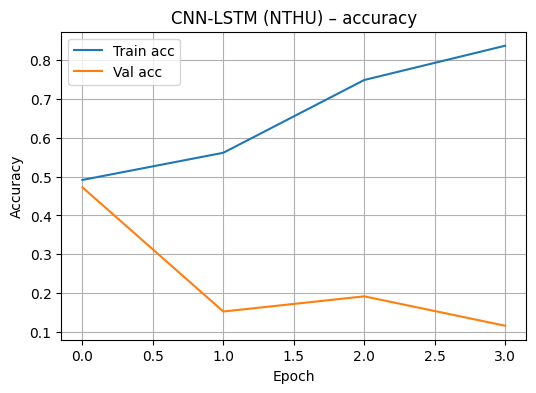

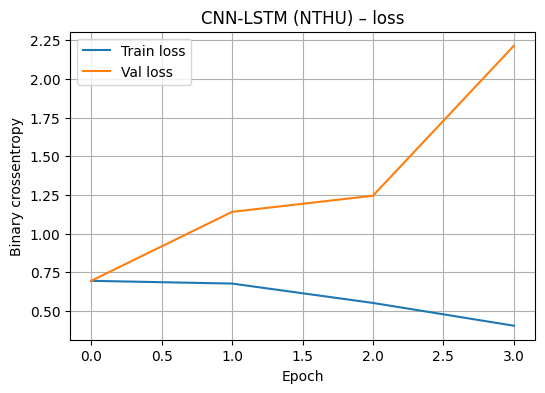

Loaded best model from: Models/cnn_lstm_nthu_seq16_v2.keras
y_true shape: (1175,)
y_scores shape: (1175,)

Validation class distribution (from y_true) [1=drowsy,0=notdrowsy]:
  class 0: 555 clips
  class 1: 620 clips

Classification report (CNN-LSTM, threshold=0.50)
               precision    recall  f1-score   support

notdrowsy (0)       0.47      1.00      0.64       555
   drowsy (1)       0.00      0.00      0.00       620

     accuracy                           0.47      1175
    macro avg       0.24      0.50      0.32      1175
 weighted avg       0.22      0.47      0.30      1175

Confusion matrix (rows=true, cols=pred) [0=notdrowsy, 1=drowsy]:
[[555   0]
 [620   0]]

ROC AUC (drowsy=1): 0.063


/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

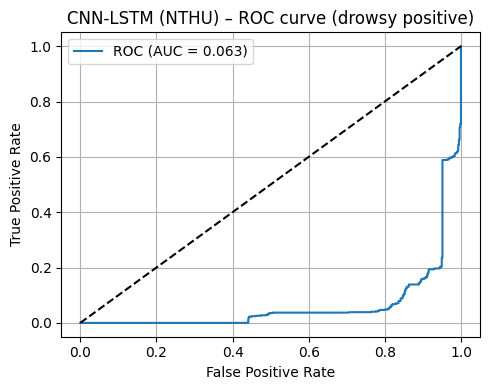


Threshold sweep for drowsy (1):
  thr=0.10 -> F1(drowsy)= 0.691, recall(drowsy)= 1.000, precision(drowsy)= 0.528
  thr=0.20 -> F1(drowsy)= 0.691, recall(drowsy)= 1.000, precision(drowsy)= 0.528
  thr=0.30 -> F1(drowsy)= 0.691, recall(drowsy)= 1.000, precision(drowsy)= 0.528
  thr=0.40 -> F1(drowsy)= 0.691, recall(drowsy)= 1.000, precision(drowsy)= 0.528
  thr=0.50 -> F1(drowsy)= 0.000, recall(drowsy)= 0.000, precision(drowsy)= 0.000
  thr=0.60 -> F1(drowsy)= 0.000, recall(drowsy)= 0.000, precision(drowsy)= 0.000
  thr=0.70 -> F1(drowsy)= 0.000, recall(drowsy)= 0.000, precision(drowsy)= 0.000
  thr=0.80 -> F1(drowsy)= 0.000, recall(drowsy)= 0.000, precision(drowsy)= 0.000
  thr=0.90 -> F1(drowsy)= 0.000, recall(drowsy)= 0.000, precision(drowsy)= 0.000


In [ ]:
### 0. Imports & paths

import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
    f1_score,
)

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# Make sure we are in the project root (Azure layout)
print("CWD before:", os.getcwd())
if os.path.basename(os.getcwd()) == "code":
    if os.path.exists("Deep-Learning-Drowsiness-Prediction"):
        os.chdir("Deep-Learning-Drowsiness-Prediction")
print("CWD now:", os.getcwd())

# NTHU data root
nthu_root = "Data/NTHU_DDD/train_data"
print("NTHU root:", os.path.abspath(nthu_root))
print("Subfolders in NTHU:", os.listdir(nthu_root))

### 1. Build metadata for all NTHU frames (FIXED sequence_id)

def parse_nthu_name(path_str):
    """
    Parse filename like:
      001_glasses_sleepyCombination_1000_drowsy.jpg
    into components.
    """
    name = Path(path_str).stem
    parts = name.split("_")

    if len(parts) < 5:
        return {
            "filepath": path_str,
            "subject": "unknown",
            "accessory": "unknown",
            "scenario": "unknown",
            "sequence_id": "unknown",
            "frame_idx": -1,
            "label_from_name": "unknown",
        }

    subject_id      = parts[0]      # '001'
    accessory       = parts[1]      # 'glasses', 'noglasses', etc.
    scenario        = parts[2]      # 'sleepyCombination', 'nonsleepyCombination', ...
    frame_idx       = int(parts[3]) # 0, 1, 2, ...
    label_from_name = parts[4]      # 'drowsy' or 'notdrowsy' (depends on dataset)

    base_sequence_id = "_".join(parts[:3])  # e.g. '001_glasses_sleepyCombination'

    return {
        "filepath": path_str,
        "subject": subject_id,
        "accessory": accessory,
        "scenario": scenario,
        "sequence_id": base_sequence_id,  # we'll overwrite below
        "frame_idx": frame_idx,
        "label_from_name": label_from_name,
    }

rows = []
for cls_name in ["drowsy", "notdrowsy"]:
    cls_folder = os.path.join(nthu_root, cls_name)
    cls_files = (
        glob(os.path.join(cls_folder, "*.png"))
        + glob(os.path.join(cls_folder, "*.jpg"))
        + glob(os.path.join(cls_folder, "*.jpeg"))
    )
    print(f"{cls_name} – found {len(cls_files)} images")

    for f in cls_files:
        info = parse_nthu_name(f)
        info["folder_label"] = cls_name
        info["sequence_base"] = info["sequence_id"]

        # 🔑 make sequence_id unique per folder + sequence
        # so we get things like:
        #   'drowsy_001_glasses_sleepyCombination'
        #   'notdrowsy_001_glasses_sleepyCombination'
        info["sequence_id"] = f"{cls_name}_{info['sequence_base']}"

        # 🔑 final label: 1 = drowsy, 0 = notdrowsy
        info["label"] = 1 if cls_name == "drowsy" else 0

        rows.append(info)

nthu_meta = pd.DataFrame(rows)
print("Metadata shape:", nthu_meta.shape)

print("\nLabel from filename (label_from_name) counts:")
print(nthu_meta["label_from_name"].value_counts())

print("\nNumeric label distribution (1=drowsy,0=notdrowsy):")
print(nthu_meta["label"].value_counts())

# ✅ sanity check: now each sequence should have only ONE label
seq_label_check = (
    nthu_meta.groupby("sequence_id")["label"]
    .nunique()
    .reset_index()
    .rename(columns={"label": "num_unique_labels"})
)
multi_label_seqs = seq_label_check[seq_label_check["num_unique_labels"] > 1]
if not multi_label_seqs.empty:
    print("\nWARNING: Some sequences STILL have multiple labels:")
    print(multi_label_seqs.head())
else:
    print("\nAll sequences have a single label per sequence_id now (GOOD).")

### 2. Sequence-level stats & balanced train/val split

# Aggregate per sequence: label + num_frames
seq_info = (
    nthu_meta
    .groupby("sequence_id")
    .agg(
        label      = ("label", "first"),
        num_frames = ("frame_idx", "count"),
    )
    .reset_index()
)

print("\nNumber of unique sequences:", seq_info["sequence_id"].nunique())
print("Min frames per sequence:", seq_info["num_frames"].min())
print("Max frames per sequence:", seq_info["num_frames"].max())

print("\nBasic stats for frames per sequence:")
print(seq_info["num_frames"].describe())

print("\nSequences per class (1=drowsy,0=notdrowsy):")
print(seq_info["label"].value_counts())

# Balanced train/val split by sequence, per class (≈80/20)
rng = np.random.RandomState(42)

drowsy_seqs     = seq_info[seq_info["label"] == 1]["sequence_id"].values
notdrowsy_seqs  = seq_info[seq_info["label"] == 0]["sequence_id"].values

n_drowsy        = len(drowsy_seqs)
n_notdrowsy     = len(notdrowsy_seqs)

n_train_drowsy    = max(1, int(0.8 * n_drowsy))
n_train_notdrowsy = max(1, int(0.8 * n_notdrowsy))

train_drowsy_seqs = rng.choice(drowsy_seqs, size=n_train_drowsy, replace=False)
train_notd_seqs   = rng.choice(notdrowsy_seqs, size=n_train_notdrowsy, replace=False)

train_seqs = set(train_drowsy_seqs.tolist() + train_notd_seqs.tolist())
val_seqs   = set(seq_info["sequence_id"].values) - train_seqs

print("\nTotal sequences:", len(seq_info))
print("Train sequences:", len(train_seqs))
print("Val sequences:  ", len(val_seqs))

# Check class balance per split at sequence level
seq_info["split"] = seq_info["sequence_id"].apply(
    lambda s: "train" if s in train_seqs else "val"
)

print("\ntrain split – sequences per class (1=drowsy,0=notdrowsy):")
print(seq_info[seq_info["split"] == "train"]["label"].value_counts())

print("\nval split – sequences per class (1=drowsy,0=notdrowsy):")
print(seq_info[seq_info["split"] == "val"]["label"].value_counts())

# Propagate split tags down to frame-level metadata
split_map = dict(zip(seq_info["sequence_id"], seq_info["split"]))
nthu_meta["split"] = nthu_meta["sequence_id"].map(split_map)

# Frame-level distribution per split
frame_split_counts = (
    nthu_meta
    .groupby(["split", "label"])["filepath"]
    .count()
    .reset_index()
    .rename(columns={"filepath": "count"})
)
frame_split_counts["total_in_split"] = frame_split_counts.groupby("split")["count"].transform("sum")
frame_split_counts["ratio"] = frame_split_counts["count"] / frame_split_counts["total_in_split"]

print("\nFrame-level counts by split and label (1=drowsy,0=notdrowsy):")
print(frame_split_counts)

# Save metadata if needed
os.makedirs("Data/NTHU_DDD", exist_ok=True)
meta_path = "Data/NTHU_DDD/nthu_metadata_with_split_v2.csv"
nthu_meta.to_csv(meta_path, index=False)
print("\nSaved NTHU metadata with splits to:", meta_path)


### 3. Build fixed-length clips from sequences

IMG_SIZE = (64, 64)
IMG_H, IMG_W = IMG_SIZE
SEQ_LEN = 16      # frames per clip (kept small for GPU)
STRIDE  = 16      # non-overlapping clips

def build_clip_index(meta_df, split, seq_len=16, stride=16):
    """
    Build clip indices for given split.

    Returns:
      paths_arr:  (num_clips, seq_len) array of filepaths
      labels_arr: (num_clips,) array of 0/1 labels (1=drowsy)
    """
    clip_paths = []
    clip_labels = []

    split_df = meta_df[meta_df["split"] == split]

    for seq_id, group in split_df.groupby("sequence_id"):
        group = group.sort_values("frame_idx")
        paths = group["filepath"].values
        label = group["label"].iloc[0]   # 1=drowsy, 0=notdrowsy

        if len(paths) < seq_len:
            continue

        # Slide with stride
        for start in range(0, len(paths) - seq_len + 1, stride):
            window = paths[start:start+seq_len]
            clip_paths.append(window)
            clip_labels.append(label)

    return np.array(clip_paths), np.array(clip_labels)

train_paths_arr, train_labels_arr = build_clip_index(
    nthu_meta, split="train", seq_len=SEQ_LEN, stride=STRIDE
)
val_paths_arr, val_labels_arr = build_clip_index(
    nthu_meta, split="val", seq_len=SEQ_LEN, stride=STRIDE
)

print("\nInitial clip arrays:")
print("train_paths_arr shape:", train_paths_arr.shape)
print("train_labels_arr shape:", train_labels_arr.shape)
print("val_paths_arr shape:",   val_paths_arr.shape)
print("val_labels_arr shape:",  val_labels_arr.shape)

print("\nInitial train class distribution (1=drowsy,0=notdrowsy):")
print(pd.Series(train_labels_arr).value_counts())

print("\nInitial val class distribution (1=drowsy,0=notdrowsy):")
print(pd.Series(val_labels_arr).value_counts())


### 4. Balance training clips by class (downsample majority)

def balance_clips(paths_arr, labels_arr, rng, max_per_class=None):
    """
    Downsample majority class so that both classes have the same #clips.
    Optionally cap per-class clips at max_per_class.
    """
    labels = np.array(labels_arr)
    idx_pos = np.where(labels == 1)[0]   # drowsy
    idx_neg = np.where(labels == 0)[0]   # notdrowsy

    n_pos = len(idx_pos)
    n_neg = len(idx_neg)

    if n_pos == 0 or n_neg == 0:
        print("WARNING: cannot balance because one class is missing.")
        return paths_arr, labels_arr

    n_min = min(n_pos, n_neg)
    if max_per_class is not None:
        n_target = min(n_min, max_per_class)
    else:
        n_target = n_min

    idx_pos_sample = rng.choice(idx_pos, size=n_target, replace=False)
    idx_neg_sample = rng.choice(idx_neg, size=n_target, replace=False)

    idx_all = np.concatenate([idx_pos_sample, idx_neg_sample])
    rng.shuffle(idx_all)

    balanced_paths  = paths_arr[idx_all]
    balanced_labels = labels_arr[idx_all]

    return balanced_paths, balanced_labels

# Balance train clips
train_paths_bal, train_labels_bal = balance_clips(
    train_paths_arr,
    train_labels_arr,
    rng=rng,
    max_per_class=None,   # or set a cap if you want smaller training set
)

print("\nAfter balancing training clips:")
print("train_paths_bal shape:", train_paths_bal.shape)
print("train_labels_bal shape:", train_labels_bal.shape)
print("Balanced train class distribution (1=drowsy,0=notdrowsy):")
print(pd.Series(train_labels_bal).value_counts())

print("\nVal class distribution (1=drowsy,0=notdrowsy) [kept natural]:")
print(pd.Series(val_labels_arr).value_counts())


### 5. tf.data pipelines for sequence clips (with light augmentation)

AUTOTUNE      = tf.data.AUTOTUNE
BATCH_SIZE_SEQ = 4   # sequences (clips) per batch

def load_and_preprocess_image(path, training):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=1)
    img.set_shape([None, None, 1])             # static rank
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)

    return img  # (H, W, 1)

def paths_to_clip(paths, label, training):
    def _load(p):
        return load_and_preprocess_image(p, training=training)

    clip = tf.map_fn(
        _load,
        paths,
        fn_output_signature=tf.float32,
        parallel_iterations=SEQ_LEN,
        back_prop=False,
    )  # -> (SEQ_LEN, H, W, 1)
    clip.set_shape((SEQ_LEN, IMG_H, IMG_W, 1))
    return clip, label

def make_seq_dataset(paths_arr, labels_arr, batch_size, training):
    ds = tf.data.Dataset.from_tensor_slices((paths_arr, labels_arr))
    if training:
        ds = ds.shuffle(buffer_size=len(paths_arr), reshuffle_each_iteration=True)

    ds = ds.map(
        lambda paths, label: paths_to_clip(paths, label, training=training),
        num_parallel_calls=AUTOTUNE,
    )
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_seq_ds = make_seq_dataset(
    train_paths_bal, train_labels_bal,
    batch_size=BATCH_SIZE_SEQ,
    training=True,
)
val_seq_ds = make_seq_dataset(
    val_paths_arr, val_labels_arr,
    batch_size=BATCH_SIZE_SEQ,
    training=False,
)

# Sanity check one batch
seq_batch, label_batch = next(iter(train_seq_ds))
print("\nseq_batch shape:", seq_batch.shape)   # (B, SEQ_LEN, 64, 64, 1)
print("label_batch shape:", label_batch.shape)
print("First batch labels:", label_batch.numpy())



In [47]:
print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)

# Sanity: average score per class
mean_score_notdrowsy = y_scores[y_true == 0].mean()
mean_score_drowsy    = y_scores[y_true == 1].mean()
print("Mean score for notdrowsy (0):", mean_score_notdrowsy)
print("Mean score for drowsy    (1):", mean_score_drowsy)

y_true shape: (1175,)
y_scores shape: (1175,)
Mean score for notdrowsy (0): 0.4944812
Mean score for drowsy    (1): 0.4937257


Evaluating on validation clips...
y_true shape: (1175,)
y_scores_raw shape: (1175,)
Mean raw score for class 0: 0.494481
Mean raw score for class 1: 0.493726
AUC if we treat raw scores as P(class 1): 0.063
AUC if we treat 1 - score as P(class 1): 0.937
>> Flipping scores (using 1 - raw) as P(class 1).
Using AUC = 0.937 for evaluation.

Best threshold for class 1 (by F1): 0.100
Best F1 (class 1): 0.691

Classification report at best threshold:
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       555
     class 1       0.53      1.00      0.69       620

    accuracy                           0.53      1175
   macro avg       0.26      0.50      0.35      1175
weighted avg       0.28      0.53      0.36      1175

Confusion matrix at best threshold (rows=true, cols=pred) [0,1]:
[[  0 555]
 [  0 620]]


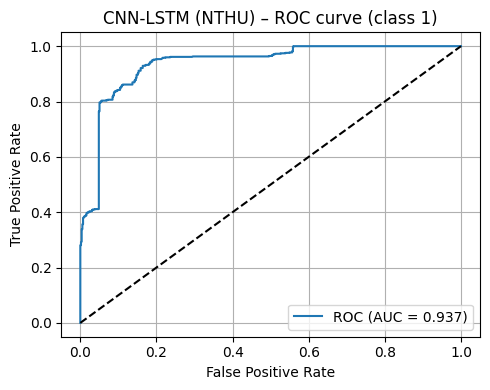

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np

# 1. Collect predictions on validation set
print("Evaluating on validation clips...")

y_true = []
y_scores_raw = []

for clips, labels in val_seq_ds:
    probs = cnn_lstm.predict(clips, verbose=0).ravel()
    y_scores_raw.extend(probs)
    y_true.extend(labels.numpy().ravel())

y_true = np.array(y_true).astype(int)      # 0/1 labels from dataset
y_scores_raw = np.array(y_scores_raw)      # as output by the model

print("y_true shape:", y_true.shape)
print("y_scores_raw shape:", y_scores_raw.shape)

# 2. Quick sanity: mean score by class
mean_score_0 = y_scores_raw[y_true == 0].mean()
mean_score_1 = y_scores_raw[y_true == 1].mean()
print(f"Mean raw score for class 0: {mean_score_0:.6f}")
print(f"Mean raw score for class 1: {mean_score_1:.6f}")

# 3. Compute AUC for both interpretations:
#    (a) scores = P(class 1)  (what we intended)
#    (b) scores = P(class 0) = 1 - P(class 1)
fpr_a, tpr_a, _ = roc_curve(y_true, y_scores_raw, pos_label=1)
auc_a = auc(fpr_a, tpr_a)

y_scores_flipped = 1.0 - y_scores_raw
fpr_b, tpr_b, _ = roc_curve(y_true, y_scores_flipped, pos_label=1)
auc_b = auc(fpr_b, tpr_b)

print(f"AUC if we treat raw scores as P(class 1): {auc_a:.3f}")
print(f"AUC if we treat 1 - score as P(class 1): {auc_b:.3f}")

# Decide which direction carries more signal
if auc_b > auc_a:
    print(">> Flipping scores (using 1 - raw) as P(class 1).")
    y_scores = y_scores_flipped
    auc_used = auc_b
else:
    print(">> Using raw scores as P(class 1).")
    y_scores = y_scores_raw
    auc_used = auc_a

print(f"Using AUC = {auc_used:.3f} for evaluation.")

# 4. Threshold sweep to find a reasonable operating point
thresholds = np.linspace(0.1, 0.9, 33)
best_f1 = -1.0
best_thr = 0.5
best_report = None
best_cm = None

for thr in thresholds:
    y_pred = (y_scores >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(
        y_true, y_pred,
        target_names=["class 0", "class 1"],
        output_dict=True,
        zero_division=0
    )
    f1_class1 = report["class 1"]["f1-score"]
    if f1_class1 > best_f1:
        best_f1 = f1_class1
        best_thr = thr
        best_cm = cm
        best_report = report

print(f"\nBest threshold for class 1 (by F1): {best_thr:.3f}")
print(f"Best F1 (class 1): {best_f1:.3f}")

# 5. Pretty-print the report at the best threshold
y_pred_best = (y_scores >= best_thr).astype(int)
print("\nClassification report at best threshold:")
print(classification_report(
    y_true, y_pred_best,
    target_names=["class 0", "class 1"],
    zero_division=0
))

print("Confusion matrix at best threshold (rows=true, cols=pred) [0,1]:")
print(best_cm)

# 6. ROC curve (using the chosen score direction)
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
roc_auc_used = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_used:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN-LSTM (NTHU) – ROC curve (class 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()